# Data download and processing from Swissprot

Downloaded the data on 13th of May 2024. 571,282 results filtering for reviewed "Swiss-Prot". (https://www.uniprot.org/uniprotkb?query=*&facets=reviewed%3Atrue)

Selected download TSV and the columns, Seqeunce (under Sequences tab), EC number (under Function).

Unzipped the downloaded file.

## 1. Protein to EC processing


In [1]:
import pandas as pd

swissprot = pd.read_csv('raw_data/uniprotkb_AND_reviewed_true_2024_05_13.tsv', sep='\t')
swissprot

,Entry,Entry Name,Length,Sequence,EC number
0,A0A009IHW8,ABTIR_ACIB9,269,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.-; 3.2.2.6
1,A0A023I7E1,ENG1_RHIMI,796,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,3.2.1.39
2,A0A024B7W1,POLG_ZIKVF,3423,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
3,A0A024SC78,CUTI1_HYPJR,248,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,3.1.1.74
4,A0A024SH76,GUX2_HYPJR,471,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,3.2.1.91
...,...,...,...,...,...
571277,V9HVX0,YPAA_ECOLI,61,MTIAERLRQEGHQIGWQEGKLEGLHEQAIKIALRMLEQGFDRDQVL...,NaN
571278,W5X2N3,AP_FRAAN,193,MGWVWKDDDEQGGHVNPSAADISPRLDGDRCSTRKVVRTQCKTEEV...,NaN
571279,W6JGV7,REP_CPBDV,484,MSAPLSIEQDDLLTDDLKSWLSDIDFSNDNEEAIEMEPSDIEMSSP...,NaN
571280,W6JHZ8,VP1_CPBDV,210,MNVKGASDKAQLAMQAEWEEVLAPEGALAVEEASSVLKISDDERRS...,NaN


## Explode out EC number so each EC has it's own row

In [2]:
# Drop rows that don't have an ec number
swissprot = swissprot[swissprot['EC number'].notna()]
print(len(swissprot))
swissprot['EC All'] = swissprot['EC number'].values
print(len(swissprot))
# Now expand out the ones we have left
swissprot['EC number'] = [ec.split(';') for ec in swissprot['EC number']]
# Then check how many have mulitple
print(sum([1 if len(ec) > 1 else 0 for ec in swissprot['EC number'].values]))
swissprot = swissprot.explode('EC number')
# Clean the EC numbers
swissprot['EC number'] = [ec.replace(' ', '') for ec in swissprot['EC number']]
swissprot

275960
275960
18356


/tmp/ipykernel_431686/1897238878.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swissprot['EC All'] = swissprot['EC number'].values
/tmp/ipykernel_431686/1897238878.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swissprot['EC number'] = [ec.split(';') for ec in swissprot['EC number']]


,Entry,Entry Name,Length,Sequence,EC number,EC All
0,A0A009IHW8,ABTIR_ACIB9,269,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.-,3.2.2.-; 3.2.2.6
0,A0A009IHW8,ABTIR_ACIB9,269,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.6,3.2.2.-; 3.2.2.6
1,A0A023I7E1,ENG1_RHIMI,796,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,3.2.1.39,3.2.1.39
2,A0A024B7W1,POLG_ZIKVF,3423,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.1.1.56,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
2,A0A024B7W1,POLG_ZIKVF,3423,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.1.1.57,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
...,...,...,...,...,...,...
570995,Q9Z7Q0,Y654_CHLPN,155,MLKKKPVSFSCIDGHIYKIFPNDLNANNTVFGGLLMSLLDRLALVV...,3.1.2.-,3.1.2.-
571093,Q9ZD84,Y459_RICPR,226,MIDKSSADILEISAKCGYLTGLLKNVYRSANIIVTDMSPLLLDSFD...,2.1.1.-,2.1.1.-
571104,Q9ZDD5,Y396_RICPR,208,MKKIIFCFLYLYTLNVFGASKIDHNKLNSCSITRNIFNNYEPKVFE...,1.13.11.-,1.13.11.-
571116,Q9ZDI9,Y339_RICPR,318,MKQNIYSPLVSIIIPVYNGANYMREAIDSALAQTYKNIEIIVVNDG...,2.4.-.-,2.4.-.-


## Filtering steps 

* Filter to a certain sequence length
* Drop duplicates
* Remove EC numbers with dash

In [3]:
swissprot = swissprot[~swissprot['EC number'].str.contains('-')]
print('Partially filled EC numbers: ', len(swissprot))
swissprot = swissprot.drop_duplicates(subset=['Sequence', 'EC number'])
print(len(swissprot))
swissprot

Partially filled EC numbers:  253572
215372


,Entry,Entry Name,Length,Sequence,EC number,EC All
0,A0A009IHW8,ABTIR_ACIB9,269,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.6,3.2.2.-; 3.2.2.6
1,A0A023I7E1,ENG1_RHIMI,796,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,3.2.1.39,3.2.1.39
2,A0A024B7W1,POLG_ZIKVF,3423,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.1.1.56,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
2,A0A024B7W1,POLG_ZIKVF,3423,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.1.1.57,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
2,A0A024B7W1,POLG_ZIKVF,3423,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.7.7.48,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
...,...,...,...,...,...,...
564731,Q6HX62,Y3032_BACAN,584,MGQNQFRWSNEQLREHVEIIDGTRSPHKLLKNATYLNSYIREWMQA...,3.5.4.2,3.5.4.2
564754,Q6L032,Y1085_PICTO,573,MLLKNIKISNDYNIFMIIASRKPSLKDIYKIIKVSKFDEPADLIIE...,3.5.4.2,3.5.4.2
565753,Q7TDB6,RDRP_MYRV9,1354,MSLTSRYTHFVPDSTITEILNDSNTPQILLHYANIVNGSTPVHFTS...,2.7.7.48,2.7.7.48
568711,Q94MV8,VG56_BPLZ5,172,MAHFNECAHLIEGVDKANRAYAENIMHNIDPLQVMLDMQRHLQIRL...,3.6.1.12,3.6.1.12


### Comparison to the dataset used in CLEAN

CLEAN: https://www.science.org/doi/10.1126/science.adf2465 


Dataset was downloaded from the CLEA repository: https://github.com/tttianhao/CLEAN/tree/main/app/data specifically the split 100 dataset, alternatively they can be downloaded from: https://drive.google.com/file/d/1MzYQ--CRK253eAKOmZrD1nzF-mXHfXtq/view


In [4]:
clean_df = pd.read_csv('raw_data/CLEAN_split100.tsv', sep='\t')
clean_df = clean_df.drop_duplicates(subset=['Sequence', 'EC number'])
clean_df['Length'] = [len(seq) for seq in clean_df['Sequence']]
clean_df

,Entry,EC number,Sequence,Length
0,P51451,2.7.10.2,MGLVSSKKPDKEKPIKEKDKGQWSPLKVSAQDKDAPPLPPLVVFNH...,505
1,C7C422,3.5.2.6,MELPNIMHPVAKLSTALAAALMLSGCMPGEIRPTIGQQMETGDQRF...,270
2,Q07457,2.3.2.27,MTAEPATKKIKLELSDPSEPLTQSDVIAFQKEALFRCINRRRVDFE...,700
3,Q07009,3.4.22.53,MAGIAMKLAKDREAAEGLGSHERAIKYLNQDYETLRNECLEAGALF...,700
4,Q9TTH8,3.4.22.54,MPTVISASVAPRTGAEPRSPGPIAQAAQGKGTEAGGGNPSGIYSAI...,822
...,...,...,...,...
227357,Q97HD1,3.1.11.6,MPSKKESYESMIKELEKIVSSMENEELPLEEAMKNYEDGVKLCDKL...,77
227358,A0A140CUL9,1.1.99.13,MAENNTYDAIVIGSGISGGWATKELTEKGLKTLMLERGRNIEHVKD...,562
227359,W6JQJ6,1.13.12.2,MNKNNRHPADGKKPITIFGPDFPFAFDDWLEHPAGLGSIPAARHGE...,560
227360,B3IVI7,3.5.1.30,MRIALYQGAPKPLDVPGNLQRLRHQAQLAAERGAQLLVCPEMFLTG...,264


## 2. Reaction to EC processing

EC and reaction data were downloaded from multiple sources, the first being ECReact.

1. ECReact: https://www.nature.com/articles/s41467-022-28536-w, with the data downloaded from https://github.com/rxn4chemistry/biocatalysis-model specifically, https://github.com/rxn4chemistry/biocatalysis-model/blob/main/data/ecreact-1.0.csv
2. EnzymeMap: https://chemrxiv.org/engage/chemrxiv/article-details/643e9f4034f4ff2ea4f4f84e https://zenodo.org/records/8254726 and the data https://github.com/hesther/enzymemap, using the data file https://github.com/hesther/enzymemap/blob/main/data/processed_reactions.csv.gz

In [5]:
ECreact = pd.read_csv('raw_data/ECReact.csv')
ECreact['rxn_smiles'] = ECreact['rxn_smiles'].str.split('|').str[0] + '>>' + ECreact['rxn_smiles'].str.split('>>').str[1]
ECreact.rename(columns={'rxn_smiles': 'Reaction', 'ec': 'EC number', 'source':'Source'}, inplace=True)
ECreact

,Reaction,EC number,Source
0,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,1.2.1.8,brenda_reaction_smiles
1,C=C(C)CCOP(=O)([O-])OP(=O)([O-])[O-].CC(C)=CCO...,2.5.1.85,brenda_reaction_smiles
2,N.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O...,1.4.1.4,brenda_reaction_smiles
3,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,1.1.1.3,brenda_reaction_smiles
4,Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O...,2.7.7.9,brenda_reaction_smiles
...,...,...,...
62217,CCCCC/C=C\C/C=C\C/C=C\C/C=C\C/C=C\CCC(=O)O[C@@...,2.3.1.76,pathbank_reaction_smiles
62218,CCCCCCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)(O...,2.7.8.41,pathbank_reaction_smiles
62219,CCCCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCCCCC...,2.7.8.41,pathbank_reaction_smiles
62220,CCCCCC/C=C\CCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCC...,2.7.8.41,pathbank_reaction_smiles


In [6]:
enzymemap = pd.read_csv('raw_data/EnzymeMap.csv')
print(len(enzymemap))
enzymemap.rename(columns={'ec_num': 'EC number', 'unmapped': 'Reaction', 'mapped': 'Mapped Reaction', 'orig_rxn_text':'Reaction Text'}, inplace=True)
enzymemap = enzymemap[['Reaction', 'Mapped Reaction', 'EC number', 'Reaction Text']]
enzymemap.drop_duplicates(subset=['Reaction', 'EC number'], inplace=True)
enzymemap

349458


,Reaction,Mapped Reaction,EC number,Reaction Text
0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
1,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...,[CH3:1][CH2:2][OH:3].[NH2:4][C:5](=[O:6])[c:7]...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
25,CC(=O)C=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)...,[CH3:1][C:2](=[O:3])[CH:4]=[O:5].[H+].[NH2:6][...,1.1.1.1,methylglyoxal + NADH + H+ = acetol + NAD+ {r}
26,CC(=O)CO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)...,[CH3:1][C:2](=[O:3])[CH2:4][OH:5].[NH2:6][C:7]...,1.1.1.1,methylglyoxal + NADH + H+ = acetol + NAD+ {r}
27,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,1.1.1.1,2-dehydro-3-deoxy-D-gluconate + NADH + H+ = 4-...
...,...,...,...,...
349453,CC(C)=CCOP(=O)(O)OP(=O)(O)O.Nc1ncnc2c1ncn2[C@@...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][O:6][P:7](...,6.5.1.3,ATP + dimethylallyl diphosphate = dimethylally...
349454,CC(C)=CCC/C(C)=C/COP(=O)(O)OP(=O)(O)O.Nc1ncnc2...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,6.5.1.3,ATP + geranyl diphosphate = geranyl-triphospho...
349455,CC(C)=CCC/C(C)=C/COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,6.5.1.3,ATP + geranyl triphosphate = geranyl-tetraphos...
349456,C=C(C)CCOP(=O)(O)OP(=O)(O)O.Nc1ncnc2c1ncn2[C@@...,[CH2:1]=[C:2]([CH3:3])[CH2:4][CH2:5][O:6][P:7]...,6.5.1.3,ATP + isopentenyl diphosphate = adenosine 5'-i...


In [7]:
enzymemap.dropna(subset=['Mapped Reaction'])

,Reaction,Mapped Reaction,EC number,Reaction Text
0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
1,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...,[CH3:1][CH2:2][OH:3].[NH2:4][C:5](=[O:6])[c:7]...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
25,CC(=O)C=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)...,[CH3:1][C:2](=[O:3])[CH:4]=[O:5].[H+].[NH2:6][...,1.1.1.1,methylglyoxal + NADH + H+ = acetol + NAD+ {r}
26,CC(=O)CO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)...,[CH3:1][C:2](=[O:3])[CH2:4][OH:5].[NH2:6][C:7]...,1.1.1.1,methylglyoxal + NADH + H+ = acetol + NAD+ {r}
27,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,1.1.1.1,2-dehydro-3-deoxy-D-gluconate + NADH + H+ = 4-...
...,...,...,...,...
349453,CC(C)=CCOP(=O)(O)OP(=O)(O)O.Nc1ncnc2c1ncn2[C@@...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][O:6][P:7](...,6.5.1.3,ATP + dimethylallyl diphosphate = dimethylally...
349454,CC(C)=CCC/C(C)=C/COP(=O)(O)OP(=O)(O)O.Nc1ncnc2...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,6.5.1.3,ATP + geranyl diphosphate = geranyl-triphospho...
349455,CC(C)=CCC/C(C)=C/COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,6.5.1.3,ATP + geranyl triphosphate = geranyl-tetraphos...
349456,C=C(C)CCOP(=O)(O)OP(=O)(O)O.Nc1ncnc2c1ncn2[C@@...,[CH2:1]=[C:2]([CH3:3])[CH2:4][CH2:5][O:6][P:7]...,6.5.1.3,ATP + isopentenyl diphosphate = adenosine 5'-i...


### Append EC numbers that are covered by ECreact but not by EnzymeMap, to EnzymeMap

In [8]:
#find the EC numbers covered by ECreact but not by enzymemap
ECreact = ECreact[~ECreact['EC number'].str.contains('-')]
not_covered = ECreact[~ECreact['EC number'].isin(enzymemap['EC number'].unique())]
not_covered['EC number'].nunique()

2353

In [9]:
reaction2EC = pd.concat((enzymemap, not_covered[['Reaction', 'EC number']])).sort_values(by='EC number')
reaction2EC

,Reaction,Mapped Reaction,EC number,Reaction Text
0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
1172,CC(C)(C)OC(=O)N1CCC(=O)C1.NC(=O)C1=CN([C@@H]2O...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,1.1.1.1,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...
1173,CC(C)(C)OC(=O)N1CC[C@H](O)C1.NC(=O)c1ccc[n+]([...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,1.1.1.1,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...
1176,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[H+].[NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([C...,1.1.1.1,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...
1177,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,1.1.1.1,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...
...,...,...,...,...
15228,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,NaN,7.6.2.j,NaN
21396,C[C@@]1(O)OC[C@H](O)C1(O)O.Nc1ncnc2c1ncn2[C@@H...,NaN,7.6.2.l,NaN
34012,*CS(=O)(=O)[O-].Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO...,NaN,7.6.2.o,NaN
15541,Cc1ncc(C[n+]2csc(CCO)c2C)c(N)n1.Nc1ncnc2c1ncn2...,NaN,7.6.2.p,NaN


## 3. Filter protein2EC and reaction2EC to intersection of their EC numbers

In [10]:
ns_swissprot = swissprot[~swissprot['EC number'].isin(reaction2EC['EC number'].unique())]
ns_swissprot

,Entry,Entry Name,Length,Sequence,EC number,EC All
11,A0A061I403,FICD_CRIGR,455,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...,2.7.7.108,2.7.7.108; 3.1.4.-
15,A0A067XR63,XTH7_DIOKA,268,MNAEGGNLHREFEITWGDGRARIHNNGGLLTLSLDRASGSGFRSKN...,2.4.1.207,2.4.1.207
16,A0A067XRK9,XTH6_DIOKA,299,MASSLTLPMAMAFTLLALSFASAMGGSMNSSRFDELFQPSWAFDHF...,2.4.1.207,2.4.1.207
17,A0A067YMX8,XTH8_DIOKA,288,MAASPYSIFAVQLLLLASWMLSSSSSNFNQDFNIAWGGGRARILNN...,2.4.1.207,2.4.1.207
86,A0A0B7P3V8,YP41B_YEAST,1104,MATPVRDETRNVIDDNISARIQSKVKTNDTVRQTPSSLRKVSIKDE...,3.1.26.4,2.7.7.49; 2.7.7.7; 3.1.26.4; 3.4.23.-
...,...,...,...,...,...,...
534459,Q9ZNA5,SAHH_ROSDO,462,MTKDFIVKDIALAEFGRKELDIAETEMPGLMALRAEYGDSKPLAGA...,3.13.2.1,3.13.2.1
534465,Q9ZNJ9,MSRB_HATHI,159,MNHKKEKEYKKLDTEKLKENLTELQYNVTQRNATEKPFLNKYDKHF...,1.8.4.12,1.8.4.12
534723,V5TD18,AMBI3_FISAU,273,MIVSTSVEQSAQFSVKSLTPFGALLEATEDHSDIQQLSIEQLCQLT...,1.14.20.11,1.14.20.11
534724,V5TES5,AMBI2_FISAU,330,MTQIINITQSKVISEQILRHVFRHRRLISDTEPCVHQPCSLCLAPH...,4.1.99.25,4.1.99.25


In [11]:
len(ns_swissprot['EC number'].unique())

456

In [12]:
swissprot = swissprot[swissprot['EC number'].isin(reaction2EC['EC number'].unique())]
swissprot # 149788

,Entry,Entry Name,Length,Sequence,EC number,EC All
0,A0A009IHW8,ABTIR_ACIB9,269,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.6,3.2.2.-; 3.2.2.6
1,A0A023I7E1,ENG1_RHIMI,796,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,3.2.1.39,3.2.1.39
2,A0A024B7W1,POLG_ZIKVF,3423,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.1.1.56,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
2,A0A024B7W1,POLG_ZIKVF,3423,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.1.1.57,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
2,A0A024B7W1,POLG_ZIKVF,3423,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.7.7.48,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
...,...,...,...,...,...,...
564731,Q6HX62,Y3032_BACAN,584,MGQNQFRWSNEQLREHVEIIDGTRSPHKLLKNATYLNSYIREWMQA...,3.5.4.2,3.5.4.2
564754,Q6L032,Y1085_PICTO,573,MLLKNIKISNDYNIFMIIASRKPSLKDIYKIIKVSKFDEPADLIIE...,3.5.4.2,3.5.4.2
565753,Q7TDB6,RDRP_MYRV9,1354,MSLTSRYTHFVPDSTITEILNDSNTPQILLHYANIVNGSTPVHFTS...,2.7.7.48,2.7.7.48
568711,Q94MV8,VG56_BPLZ5,172,MAHFNECAHLIEGVDKANRAYAENIMHNIDPLQVMLDMQRHLQIRL...,3.6.1.12,3.6.1.12


In [13]:
len(swissprot['EC number'].unique())

5088

## Save unique proteins

#save the indices corresponding to unique proteins, for downstream use
unique_protein_indices = swissprot.reset_index().drop_duplicates(subset=['Sequence']).index
with open('unique_protein_indices.txt', 'w') as f:
    for index in unique_protein_indices:
        f.write(str(index) + '\n')

In [14]:
reaction2EC = reaction2EC[reaction2EC['EC number'].isin(swissprot['EC number'].unique())]
reaction2EC

,Reaction,Mapped Reaction,EC number,Reaction Text
0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
1172,CC(C)(C)OC(=O)N1CCC(=O)C1.NC(=O)C1=CN([C@@H]2O...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,1.1.1.1,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...
1173,CC(C)(C)OC(=O)N1CC[C@H](O)C1.NC(=O)c1ccc[n+]([...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,1.1.1.1,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...
1176,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[H+].[NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([C...,1.1.1.1,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...
1177,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,1.1.1.1,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...
...,...,...,...,...
34226,CC1=C2[N+]3=C(C=C4[N+]5=C(C(C)=C6N7[C@@H]8[C@H...,NaN,7.6.2.8,NaN
34223,CC1=C2[N+]3=C(C=C4[N+]5=C(C(C)=C6N7[C@H]([C@H]...,NaN,7.6.2.8,NaN
15471,C[N+]1(C)CCC[C@H]1C(=O)[O-].Nc1ncnc2c1ncn2[C@@...,NaN,7.6.2.9,NaN
644,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...,NaN,7.6.2.9,NaN


In [15]:
reaction2EC.to_csv('../processed_data/reaction2EC.csv', index=False)

## 4. Perform protein clustering using mmseqs

Use mmseqs to identify clusters, https://github.com/soedinglab/MMseqs2

Optional parameters:

```
 --seed-sub-mat TWIN              Substitution matrix file for k-mer generation [aa:VTML80.out,nucl:nucleotide.out]
 -s FLOAT                         Sensitivity: 1.0 faster; 4.0 fast; 7.5 sensitive [4.000]
 -k INT                           k-mer length (0: automatically set to optimum) [0]
 --target-search-mode INT         target search mode (0: regular k-mer, 1: similar k-mer) [0]
 --k-score TWIN                   k-mer threshold for generating similar k-mer lists [seq:2147483647,prof:2147483647]
 --alph-size TWIN                 Alphabet size (range 2-21) [aa:21,nucl:5]
 --max-seqs INT                   Maximum results per query sequence allowed to pass the prefilter (affects sensitivity) [20]
 --split INT                      Split input into N equally distributed chunks. 0: set the best split automatically [0]
 --split-mode INT                 0: split target db; 1: split query db; 2: auto, depending on main memory [2]
 --split-memory-limit BYTE        Set max memory per split. E.g. 800B, 5K, 10M, 1G. Default (0) to all available system memory [0]
 --comp-bias-corr INT             Correct for locally biased amino acid composition (range 0-1) [1]
 --comp-bias-corr-scale FLOAT     Correct for locally biased amino acid composition (range 0-1) [1.000]
 --diag-score BOOL                Use ungapped diagonal scoring during prefilter [1]
 --exact-kmer-matching INT        Extract only exact k-mers for matching (range 0-1) [0]
 --mask INT                       Mask sequences in k-mer stage: 0: w/o low complexity masking, 1: with low complexity masking [1]
 --mask-prob FLOAT                Mask sequences is probablity is above threshold [0.900]
 --mask-lower-case INT            Lowercase letters will be excluded from k-mer search 0: include region, 1: exclude region [0]
 --min-ungapped-score INT         Accept only matches with ungapped alignment score above threshold [15]
 --add-self-matches BOOL          Artificially add entries of queries with themselves (for clustering) [0]
 --spaced-kmer-mode INT           0: use consecutive positions in k-mers; 1: use spaced k-mers [1]
 --spaced-kmer-pattern STR        User-specified spaced k-mer pattern []
 --local-tmp STR                  Path where some of the temporary files will be created []
align:
 -c FLOAT                         List matches above this fraction of aligned (covered) residues (see --cov-mode) [0.800]
 --cov-mode INT                   0: coverage of query and target
                                  1: coverage of target
                                  2: coverage of query
                                  3: target seq. length has to be at least x% of query length
                                  4: query seq. length has to be at least x% of target length
                                  5: short seq. needs to be at least x% of the other seq. length [0]
 -a BOOL                          Add backtrace string (convert to alignments with mmseqs convertalis module) [0]
 --alignment-mode INT             How to compute the alignment:
                                  0: automatic
                                  1: only score and end_pos
                                  2: also start_pos and cov
                                  3: also seq.id
                                  4: only ungapped alignment [3]
 --alignment-output-mode INT      How to compute the alignment:
                                  0: automatic
                                  1: only score and end_pos
                                  2: also start_pos and cov
                                  3: also seq.id
                                  4: only ungapped alignment
                                  5: score only (output) cluster format [0]
 --wrapped-scoring BOOL           Double the (nucleotide) query sequence during the scoring process to allow wrapped diagonal scoring around end and start [0]
 -e DOUBLE                        List matches below this E-value (range 0.0-inf) [1.000E-03]
 --min-seq-id FLOAT               List matches above this sequence identity (for clustering) (range 0.0-1.0) [0.000]
 --min-aln-len INT                Minimum alignment length (range 0-INT_MAX) [0]
 --seq-id-mode INT                0: alignment length 1: shorter, 2: longer sequence [0]
 --alt-ali INT                    Show up to this many alternative alignments [0]
 --max-rejected INT               Maximum rejected alignments before alignment calculation for a query is stopped [2147483647]
 --max-accept INT                 Maximum accepted alignments before alignment calculation for a query is stopped [2147483647]
 --score-bias FLOAT               Score bias when computing SW alignment (in bits) [0.000]
 --realign BOOL                   Compute more conservative, shorter alignments (scores and E-values not changed) [0]
 --realign-score-bias FLOAT       Additional bias when computing realignment [-0.200]
 --realign-max-seqs INT           Maximum number of results to return in realignment [2147483647]
 --corr-score-weight FLOAT        Weight of backtrace correlation score that is added to the alignment score [0.000]
 --gap-open TWIN                  Gap open cost [aa:11,nucl:5]
 --gap-extend TWIN                Gap extension cost [aa:1,nucl:2]
 --zdrop INT                      Maximal allowed difference between score values before alignment is truncated  (nucleotide alignment only) [40]
clust:
 --cluster-mode INT               0: Set-Cover (greedy)
                                  1: Connected component (BLASTclust)
                                  2,3: Greedy clustering by sequence length (CDHIT) [0]
 --max-iterations INT             Maximum depth of breadth first search in connected component clustering [1000]
 --similarity-type INT            Type of score used for clustering. 1: alignment score 2: sequence identity [2]
 --single-step-clustering BOOL    Switch from cascaded to simple clustering workflow [0]
 --cluster-steps INT              Cascaded clustering steps from 1 to -s [3]
 --cluster-reassign BOOL          Cascaded clustering can cluster sequence that do not fulfill the clustering criteria.
                                  Cluster reassignment corrects these errors [0]
kmermatcher:
 --weights STR                    Weights used for cluster priorization []
 --cluster-weight-threshold FLOAT Weight threshold used for cluster priorization [0.900]
 --kmer-per-seq INT               k-mers per sequence [21]
 --kmer-per-seq-scale TWIN        Scale k-mer per sequence based on sequence length as kmer-per-seq val + scale x seqlen [aa:0.000,nucl:0.200]
 --adjust-kmer-len BOOL           Adjust k-mer length based on specificity (only for nucleotides) [0]
 --hash-shift INT                 Shift k-mer hash initialization [67]
 --include-only-extendable BOOL   Include only extendable [0]
 --ignore-multi-kmer BOOL         Skip k-mers occurring multiple times (>=2) [0]
profile:
 --pca                            Pseudo count admixture strength []
 --pcb                            Pseudo counts: Neff at half of maximum admixture (range 0.0-inf) []
misc:
 --taxon-list STR                 Taxonomy ID, possibly multiple values separated by ',' []
 --rescore-mode INT               Rescore diagonals with:
                                  0: Hamming distance
                                  1: local alignment (score only)
                                  2: local alignment
                                  3: global alignment
                                  4: longest alignment fulfilling window quality criterion [0]
 --dbtype INT                     Database type 0: auto, 1: amino acid 2: nucleotides [0]
 --shuffle BOOL                   Shuffle input database [1]
 --createdb-mode INT              Createdb mode 0: copy data, 1: soft link data and write new index (works only with single line fasta/q) [1]
 --id-offset INT                  Numeric ids in index file are offset by this value [0]
common:
 --sub-mat TWIN                   Substitution matrix file [aa:blosum62.out,nucl:nucleotide.out]
 --max-seq-len INT                Maximum sequence length [65535]
 --db-load-mode INT               Database preload mode 0: auto, 1: fread, 2: mmap, 3: mmap+touch [0]
 --threads INT                    Number of CPU-cores used (all by default) [384]
 --compressed INT                 Write compressed output [0]
 -v INT                           Verbosity level: 0: quiet, 1: +errors, 2: +warnings, 3: +info [3]
 --remove-tmp-files BOOL          Delete temporary files [1]
 --force-reuse BOOL               Reuse tmp filse in tmp/latest folder ignoring parameters and version changes [0]
 --mpi-runner STR                 Use MPI on compute cluster with this MPI command (e.g. "mpirun -np 42") []
expert:
 --filter-hits BOOL               Filter hits by seq.id. and coverage [0]
 --sort-results INT               Sort results: 0: no sorting, 1: sort by E-value (Alignment) or seq.id. (Hamming) [0]

```

In [16]:
#generate a fasta file as input to mmseqs
with open('clustering/swissprot.fasta', 'w') as f:
    for index, row in swissprot.iterrows():
        f.write(f'>{row["Entry"]}\n{row["Sequence"]}\n')

In [17]:
!mmseqs easy-cluster clustering/swissprot.fasta clustering/clusterRes30 clustering/mmseqs_tmp --min-seq-id 0.3

easy-cluster clustering/swissprot.fasta clustering/clusterRes30 clustering/mmseqs_tmp --min-seq-id 0.3 

MMseqs Version:                     	15.6f452
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                  

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



rescorediagonal clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/linclust/10450423390545696640/input_step_redundancy clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/linclust/10450423390545696640/input_step_redundancy clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/linclust/10450423390545696640/pref_filter2 clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/linclust/10450423390545696640/pref_rescore2 --sub-mat 'aa:blosum62.out,nucl:nucleotide.out' --rescore-mode 1 --wrapped-scoring 0 --filter-hits 1 -e 0.001 -c 0.8 -a 0 --cov-mode 0 --min-seq-id 0.3 --min-aln-len 0 --seq-id-mode 0 --add-self-matches 0 --sort-results 0 --db-load-mode 0 --threads 384 --compressed 0 -v 3 

[=================================================================] 100.00% 70.32K 0s 229ms     ] 31.04% 21.83K eta 0s       ====================>                             ] 53.89% 37.90K eta 0s       K eta 0s       
Time for m

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 42.11K 0s 338ms    
Write merged clustering
[=================================================================] 100.00% 199.66K 0s 650ms    
Time for merging to clu_redundancy: 0h 0m 0s 23ms
Time for processing: 0h 0m 0s 727ms
rmdb clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/linclust/10450423390545696640/pref_filter1 -v 3 

Time for processing: 0h 0m 0s 0ms
rmdb clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/linclust/10450423390545696640/pref -v 3 

Time for processing: 0h 0m 0s 1ms
rmdb clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/linclust/10450423390545696640/pref_rescore1 -v 3 

Time for processing: 0h 0m 0s 4ms
rmdb clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/linclust/10450423390545696640/pre_clust -v 3 

Time for processing: 0h 0m 0s 0ms
rmdb clustering/mmseqs_tmp/14408087231066464626/clu_tmp/1401349

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 42.11K 1s 740ms    
Time for merging to aln_step0: 0h 0m 0s 19ms
358336 alignments calculated
302545 sequence pairs passed the thresholds (0.844305 of overall calculated)
7.184806 hits per query sequence
Time for processing: 0h 0m 1s 999ms
clust clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/input_step_redundancy clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/aln_step0 clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/clu_step0 --cluster-mode 0 --max-iterations 1000 --similarity-type 2 --threads 384 --compressed 0 -v 3 --cluster-weight-threshold 0.9 

Clustering mode: Set Cover
[=================================================================] 100.00% 42.11K 0s 180ms    s       ===================>                              ] 52.72% 22.20K eta 0s       ===============================>                  ] 71.72% 30.20K eta 0s       
Sort 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 17.10K 0s 64ms     
Sort entries
Find missing connections
Found 2043 new connections.
Reconstruct initial order
[=================================================================] 100.00% 17.10K 0s 50ms     
Add missing connections
[=================================================================] 100.00% 17.10K 0s 1ms      

Time for read in: 0h 0m 0s 192ms
Total time: 0h 0m 0s 235ms

Size of the sequence database: 17103
Size of the alignment database: 17103
Number of clusters: 13183

Writing results 0h 0m 0s 3ms
Time for merging to clu_step1: 0h 0m 0s 0ms
Time for processing: 0h 0m 0s 244ms
createsubdb clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/clu_step1 clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/input_step1 clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/input_step2 -v 3 --subdb-mode 1 

Time for merging to input_step2: 0h 0m 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 42.11K 0s 164ms    
Clustering step 2
[=================================================================] 100.00% 17.10K 0s 268ms                                  ] 33.70% 5.76K eta 0s       
Clustering step 3
[=================================================================] 100.00% 13.18K 0s 338ms    ==============================>   ] 95.23% 12.55K eta 0s       
Clustering step 4
[=================================================================] 100.00% 12.44K 0s 385ms    
Write merged clustering
[=================================================================] 100.00% 199.66K 0s 633ms    
Time for merging to clu: 0h 0m 0s 16ms===========================>] 99.18% 198.02K eta 0s       
Time for processing: 0h 0m 0s 701ms
rmdb clustering/mmseqs_tmp/14408087231066464626/clu_tmp/14013492439494345435/clu_redundancy -v 3 

Time for processing: 0h 0m 0s 3ms
rmdb clustering/mmseqs_tmp/14408087231066464626/clu_tm

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [18]:
!mmseqs easy-cluster clustering/swissprot.fasta clustering/clusterRes50 clustering/mmseqs_tmp --min-seq-id 0.5 

easy-cluster clustering/swissprot.fasta clustering/clusterRes50 clustering/mmseqs_tmp --min-seq-id 0.5 

MMseqs Version:                     	15.6f452
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                  

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 70.32K 0s 163ms    K eta 0s       
Time for merging to pref_filter2: 0h 0m 0s 28ms
Time for processing: 0h 0m 0s 438ms
rescorediagonal clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/linclust/863915286926711712/input_step_redundancy clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/linclust/863915286926711712/input_step_redundancy clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/linclust/863915286926711712/pref_filter2 clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/linclust/863915286926711712/pref_rescore2 --sub-mat 'aa:blosum62.out,nucl:nucleotide.out' --rescore-mode 1 --wrapped-scoring 0 --filter-hits 1 -e 0.001 -c 0.8 -a 0 --cov-mode 0 --min-seq-id 0.5 --min-aln-len 0 --seq-id-mode 0 --add-self-matches 0 --sort-results 0 --db-load-mode 0 --threads 384 --compressed 0 -v 3 

[==========================================

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Add missing connections
[=================================================================] 100.00% 70.32K 0s 4ms      

Time for read in: 0h 0m 0s 556ms
Total time: 0h 0m 0s 600ms

Size of the sequence database: 70321
Size of the alignment database: 70321
Number of clusters: 51365

Writing results 0h 0m 0s 7ms
Time for merging to clust: 0h 0m 0s 0ms
Time for processing: 0h 0m 0s 622ms
mergeclusters clustering/mmseqs_tmp/12628601933105198454/input clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/clu_redundancy clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/linclust/863915286926711712/pre_clust clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/linclust/863915286926711712/clust --threads 384 --compressed 0 -v 3 

Clustering step 1
[=================================================================] 100.00% 70.32K 0s 175ms    >                                                   ] 20.47% 14.40K eta 0s       ===============

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 199.66K 0s 594ms    ===========>              ] 78.37% 156.47K eta 0s       
Time for merging to clu_redundancy: 0h 0m 0s 31ms
Time for processing: 0h 0m 0s 678ms
rmdb clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/linclust/863915286926711712/pref_filter1 -v 3 

Time for processing: 0h 0m 0s 0ms
rmdb clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/linclust/863915286926711712/pref -v 3 

Time for processing: 0h 0m 0s 1ms
rmdb clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/linclust/863915286926711712/pref_rescore1 -v 3 

Time for processing: 0h 0m 0s 4ms
rmdb clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/linclust/863915286926711712/pre_clust -v 3 

Time for processing: 0h 0m 0s 0ms
rmdb clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/linclust/863915286926711712/input_step_redundancy -v 3 

T

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 51.37K 2s 30ms     
Time for merging to aln_step0: 0h 0m 0s 20ms
537417 alignments calculated
154999 sequence pairs passed the thresholds (0.288415 of overall calculated)
3.017600 hits per query sequence
Time for processing: 0h 0m 2s 346ms
clust clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/input_step_redundancy clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/aln_step0 clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/clu_step0 --cluster-mode 0 --max-iterations 1000 --similarity-type 2 --threads 384 --compressed 0 -v 3 --cluster-weight-threshold 0.9 

Clustering mode: Set Cover
[=================================================================] 100.00% 51.37K 0s 163ms    eta 0s       >                                 ] 49.11% 25.23K eta 0s       
Sort entries
Find missing connections
Found 6572 new connections.
Reconstruct initial order
[==

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 32.97K 1s 314ms    
Time for merging to aln_step1: 0h 0m 0s 24ms
283459 alignments calculated
34533 sequence pairs passed the thresholds (0.121827 of overall calculated)
1.047311 hits per query sequence
Time for processing: 0h 0m 1s 543ms
clust clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/input_step1 clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/aln_step1 clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/clu_step1 --cluster-mode 0 --max-iterations 1000 --similarity-type 2 --threads 384 --compressed 0 -v 3 --cluster-weight-threshold 0.9 

Clustering mode: Set Cover
[=================================================================] 100.00% 32.97K 0s 103ms     24.92% 8.22K eta 0s         ] 90.10% 29.71K eta 0s       
Sort entries
Find missing connections
Found 322 new connections.
Reconstruct initial order
[================================

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 32.13K 1s 436ms    
Time for merging to aln_step2: 0h 0m 0s 17ms
330884 alignments calculated
32314 sequence pairs passed the thresholds (0.097660 of overall calculated)
1.005789 hits per query sequence
Time for processing: 0h 0m 1s 673ms
clust clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/input_step2 clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/aln_step2 clustering/mmseqs_tmp/12628601933105198454/clu_tmp/11917275742316856569/clu_step2 --cluster-mode 0 --max-iterations 1000 --similarity-type 2 --threads 384 --compressed 0 -v 3 --cluster-weight-threshold 0.9 

Clustering mode: Set Cover
[=================================================================] 100.00% 32.13K 0s 93ms     K eta 0s       
Sort entries
Find missing connections
Found 36 new connections.
Reconstruct initial order
[=================================================================] 100.00% 3

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



rmdb clustering/mmseqs_tmp/12628601933105198454/input -v 3 

Time for processing: 0h 0m 0s 0ms
rmdb clustering/mmseqs_tmp/12628601933105198454/input_h -v 3 

Time for processing: 0h 0m 0s 1ms
rmdb clustering/mmseqs_tmp/12628601933105198454/clu_seqs -v 3 

Time for processing: 0h 0m 0s 17ms
rmdb clustering/mmseqs_tmp/12628601933105198454/clu_rep -v 3 

Time for processing: 0h 0m 0s 2ms
rmdb clustering/mmseqs_tmp/12628601933105198454/clu -v 3 

Time for processing: 0h 0m 0s 3ms


In [19]:
!mmseqs easy-cluster clustering/swissprot.fasta clustering/clusterRes70 clustering/mmseqs_tmp --min-seq-id 0.7 

easy-cluster clustering/swissprot.fasta clustering/clusterRes70 clustering/mmseqs_tmp --min-seq-id 0.7 

MMseqs Version:                     	15.6f452
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                  

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 91.21K 0s 199ms    ================================>                 ] 72.96% 66.54K eta 0s       
Time for merging to pref_filter2: 0h 0m 0s 30ms
Time for processing: 0h 0m 0s 512ms
rescorediagonal clustering/mmseqs_tmp/10849116635143932282/clu_tmp/8154161950232732083/linclust/16581585022965299114/input_step_redundancy clustering/mmseqs_tmp/10849116635143932282/clu_tmp/8154161950232732083/linclust/16581585022965299114/input_step_redundancy clustering/mmseqs_tmp/10849116635143932282/clu_tmp/8154161950232732083/linclust/16581585022965299114/pref_filter2 clustering/mmseqs_tmp/10849116635143932282/clu_tmp/8154161950232732083/linclust/16581585022965299114/pref_rescore2 --sub-mat 'aa:blosum62.out,nucl:nucleotide.out' --rescore-mode 1 --wrapped-scoring 0 --filter-hits 1 -e 0.001 -c 0.8 -a 0 --cov-mode 0 --min-seq-id 0.7 --min-aln-len 0 --seq-id-mode 0 --add-self-matches 0 --sort-results 0 --db-load-mode 0 --threads 3

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 91.21K 0s 153ms    
Clustering step 2
[========================================>                        ] 62.58% 49.99K eta 0s       K eta 0s       

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Index table k-mer threshold: 154 at k-mer size 6 
Index table: counting k-mers
[=================================================>               ] 76.71% 61.28K eta 0s            K eta 0s                                         ] 41.97% 33.53K eta 0s       ========>                         ] 60.46% 48.30K eta 0s       

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 79.89K 3s 297ms    
Time for merging to aln_step0: 0h 0m 0s 24ms
1091999 alignments calculated
101623 sequence pairs passed the thresholds (0.093061 of overall calculated)
1.272068 hits per query sequence
Time for processing: 0h 0m 3s 623ms
clust clustering/mmseqs_tmp/10849116635143932282/clu_tmp/8154161950232732083/input_step_redundancy clustering/mmseqs_tmp/10849116635143932282/clu_tmp/8154161950232732083/aln_step0 clustering/mmseqs_tmp/10849116635143932282/clu_tmp/8154161950232732083/clu_step0 --cluster-mode 0 --max-iterations 1000 --similarity-type 2 --threads 384 --compressed 0 -v 3 --cluster-weight-threshold 0.9 

Clustering mode: Set Cover
[=================================================================] 100.00% 79.89K 0s 228ms    ====>                                             ] 29.80% 23.81K eta 0s       ======================>                           ] 58.25% 46.53K eta 0s       
Sort entries
Fi

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 72.79K 0s 323ms      ] 83.76% 60.97K eta 0s       
Time for merging to clu_seqs: 0h 0m 0s 24ms
Time for processing: 0h 0m 0s 686ms
result2flat clustering/mmseqs_tmp/10849116635143932282/input clustering/mmseqs_tmp/10849116635143932282/input clustering/mmseqs_tmp/10849116635143932282/clu_seqs clustering/mmseqs_tmp/10849116635143932282/all_seqs.fasta -v 3 

Time for processing: 0h 0m 0s 259ms
rmdb clustering/mmseqs_tmp/10849116635143932282/input -v 3 

Time for processing: 0h 0m 0s 0ms
rmdb clustering/mmseqs_tmp/10849116635143932282/input_h -v 3 

Time for processing: 0h 0m 0s 0ms
rmdb clustering/mmseqs_tmp/10849116635143932282/clu_seqs -v 3 

Time for processing: 0h 0m 0s 13ms
rmdb clustering/mmseqs_tmp/10849116635143932282/clu_rep -v 3 

Time for processing: 0h 0m 0s 4ms
rmdb clustering/mmseqs_tmp/10849116635143932282/clu -v 3 

Time for processing: 0h 0m 0s 3ms


In [26]:
!mmseqs easy-cluster clustering/swissprot.fasta clustering/clusterRes90 clustering/mmseqs_tmp --min-seq-id 0.9 

easy-cluster clustering/swissprot.fasta clustering/clusterRes90 clustering/mmseqs_tmp --min-seq-id 0.9 

MMseqs Version:                     	15.6f452
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                  

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 128.27K 0s 221ms    
Time for merging to pref_filter2: 0h 0m 0s 42ms
Time for processing: 0h 0m 0s 627ms
rescorediagonal clustering/mmseqs_tmp/9069631337182666110/clu_tmp/1864356596365482320/linclust/15992087207317910277/input_step_redundancy clustering/mmseqs_tmp/9069631337182666110/clu_tmp/1864356596365482320/linclust/15992087207317910277/input_step_redundancy clustering/mmseqs_tmp/9069631337182666110/clu_tmp/1864356596365482320/linclust/15992087207317910277/pref_filter2 clustering/mmseqs_tmp/9069631337182666110/clu_tmp/1864356596365482320/linclust/15992087207317910277/pref_rescore2 --sub-mat 'aa:blosum62.out,nucl:nucleotide.out' --rescore-mode 1 --wrapped-scoring 0 --filter-hits 1 -e 0.001 -c 0.8 -a 0 --cov-mode 0 --min-seq-id 0.9 --min-aln-len 0 --seq-id-mode 0 --add-self-matches 0 --sort-results 0 --db-load-mode 0 --threads 384 --compressed 0 -v 3 

[==========================================>             

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 128.27K 0s 171ms    
Clustering step 2
[=============>                                                   ] 18.96% 23.82K eta 1s       

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 199.66K 0s 703ms          ] 72.25% 144.26K eta 0s       
Time for merging to clu_redundancy: 0h 0m 0s 47ms
Time for processing: 0h 0m 0s 799ms
rmdb clustering/mmseqs_tmp/9069631337182666110/clu_tmp/1864356596365482320/linclust/15992087207317910277/pref_filter1 -v 3 

Time for processing: 0h 0m 0s 0ms
rmdb clustering/mmseqs_tmp/9069631337182666110/clu_tmp/1864356596365482320/linclust/15992087207317910277/pref -v 3 

Time for processing: 0h 0m 0s 1ms
rmdb clustering/mmseqs_tmp/9069631337182666110/clu_tmp/1864356596365482320/linclust/15992087207317910277/pref_rescore1 -v 3 

Time for processing: 0h 0m 0s 4ms
rmdb clustering/mmseqs_tmp/9069631337182666110/clu_tmp/1864356596365482320/linclust/15992087207317910277/pre_clust -v 3 

Time for processing: 0h 0m 0s 0ms
rmdb clustering/mmseqs_tmp/9069631337182666110/clu_tmp/1864356596365482320/linclust/15992087207317910277/input_step_redundancy -v 3 

Time for processing: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




1.650652 k-mers per position
2063 DB matches per sequence
0 overflows
17 sequences passed prefiltering per query sequence
20 median result list length
0 sequences with 0 size result lists
Time for merging to pref_step0: 0h 0m 0s 36ms
Time for processing: 0h 0m 2s 578ms
align clustering/mmseqs_tmp/9069631337182666110/clu_tmp/1864356596365482320/input_step_redundancy clustering/mmseqs_tmp/9069631337182666110/clu_tmp/1864356596365482320/input_step_redundancy clustering/mmseqs_tmp/9069631337182666110/clu_tmp/1864356596365482320/pref_step0 clustering/mmseqs_tmp/9069631337182666110/clu_tmp/1864356596365482320/aln_step0 --sub-mat 'aa:blosum62.out,nucl:nucleotide.out' -a 0 --alignment-mode 3 --alignment-output-mode 0 --wrapped-scoring 0 -e 0.001 --min-seq-id 0.9 --min-aln-len 0 --seq-id-mode 0 --alt-ali 0 -c 0.8 --cov-mode 0 --max-seq-len 65535 --comp-bias-corr 0 --comp-bias-corr-scale 1 --max-rejected 2147483647 --max-accept 2147483647 --add-self-matches 0 --db-load-mode 0 --pca substitution

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================================] 100.00% 123.83K 0s 450ms     ] 18.99% 23.52K eta 0s                         ] 23.44% 29.02K eta 0s       K eta 0s       K eta 0s       
Time for merging to clu_seqs: 0h 0m 0s 34ms
Time for processing: 0h 0m 0s 811ms
result2flat clustering/mmseqs_tmp/9069631337182666110/input clustering/mmseqs_tmp/9069631337182666110/input clustering/mmseqs_tmp/9069631337182666110/clu_seqs clustering/mmseqs_tmp/9069631337182666110/all_seqs.fasta -v 3 

Time for processing: 0h 0m 0s 281ms
rmdb clustering/mmseqs_tmp/9069631337182666110/input -v 3 

Time for processing: 0h 0m 0s 0ms
rmdb clustering/mmseqs_tmp/9069631337182666110/input_h -v 3 

Time for processing: 0h 0m 0s 0ms
rmdb clustering/mmseqs_tmp/9069631337182666110/clu_seqs -v 3 

Time for processing: 0h 0m 0s 14ms
rmdb clustering/mmseqs_tmp/9069631337182666110/clu_rep -v 3 

Time for processing: 0h 0m 0s 6ms
rmdb clustering/mmseqs_tmp/9069631337182666110/clu -v 3 

Time for proces

32032
12439
72786
123832


,Entry,Entry Name,Sequence,EC number,Length,EC All,clusterRes50,clusterRes30,clusterRes70,clusterRes90
0,A0A009IHW8,ABTIR_ACIB9,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.6,269,3.2.2.-; 3.2.2.6,A0A009IHW8,A1AY86,A0A009IHW8,A0A009IHW8
1,A0A023I7E1,ENG1_RHIMI,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,3.2.1.39,796,3.2.1.39,A0A023I7E1,D4AZ24,A0A023I7E1,A0A023I7E1
2,A0A024B7W1,POLG_ZIKVF,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.1.1.56,3423,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...,P05769,P05769,A0A024B7W1,Q32ZE1
3,A0A024B7W1,POLG_ZIKVF,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.1.1.57,3423,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...,P05769,P05769,A0A024B7W1,Q32ZE1
4,A0A024B7W1,POLG_ZIKVF,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,2.7.7.48,3423,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...,P05769,P05769,A0A024B7W1,Q32ZE1
...,...,...,...,...,...,...,...,...,...,...
199654,Q6HX62,Y3032_BACAN,MGQNQFRWSNEQLREHVEIIDGTRSPHKLLKNATYLNSYIREWMQA...,3.5.4.2,584,3.5.4.2,Q6HX62,Q8ES91,Q6HX62,Q6HX62
199655,Q6L032,Y1085_PICTO,MLLKNIKISNDYNIFMIIASRKPSLKDIYKIIKVSKFDEPADLIIE...,3.5.4.2,573,3.5.4.2,Q6L032,Q8ES91,Q6L032,Q6L032
199656,Q7TDB6,RDRP_MYRV9,MSLTSRYTHFVPDSTITEILNDSNTPQILLHYANIVNGSTPVHFTS...,2.7.7.48,1354,2.7.7.48,Q7TDB6,Q7TDB6,Q7TDB6,Q7TDB6
199657,Q94MV8,VG56_BPLZ5,MAHFNECAHLIEGVDKANRAYAENIMHNIDPLQVMLDMQRHLQIRL...,3.6.1.12,172,3.6.1.12,P39262,P39262,Q94MV8,Q94MV8


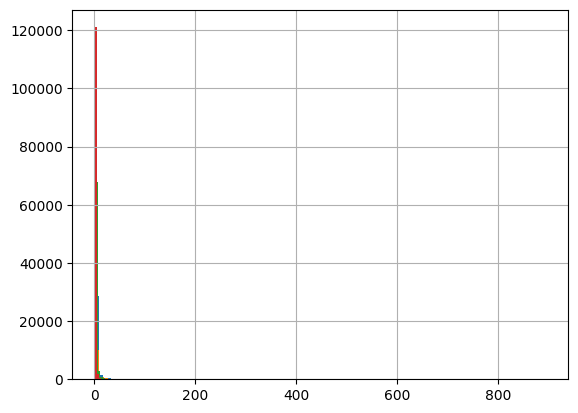

In [29]:
def process_clustering(name):
    clustering = pd.read_csv('clustering/{}_cluster.tsv'.format(name), delimiter='\t', header=None)
    #rename heading as cluster reference and id
    clustering.columns = [name, 'Entry']
    clustering.drop_duplicates(subset='Entry', keep='first', inplace=True)
    print(clustering[name].nunique())
    clustering[name].value_counts().hist(bins=100)
    return clustering

swissprot = swissprot[['Entry', 'Entry Name', 'Sequence', 'EC number', 'Length', 'EC All']]

cluster50 = process_clustering('clusterRes50')
cluster30 = process_clustering('clusterRes30')
cluster70 = process_clustering('clusterRes70')
cluster90 = process_clustering('clusterRes90')

swissprot = pd.merge(swissprot, cluster50, on='Entry', how='left')
swissprot = pd.merge(swissprot, cluster30, on='Entry', how='left')
swissprot = pd.merge(swissprot, cluster70, on='Entry', how='left')
swissprot = pd.merge(swissprot, cluster90, on='Entry', how='left')

swissprot

In [30]:
swissprot['EC3'] = swissprot['EC number'].str.split('.').str[:3].str.join('.')
swissprot['EC2'] = swissprot['EC number'].str.split('.').str[:2].str.join('.')
swissprot['EC1'] = swissprot['EC number'].str.split('.').str[:1].str.join('.')
swissprot.to_csv('../processed_data/protein2EC.csv', index=False)

# Finally process textual description of EC numbers
This is optionally used in CREEP

In [23]:
#read ECtoGO.txt line by line
ECtoGO = open("raw_data/ECtoGO_raw.txt", "r")
ECtoGO_lines = ECtoGO.readlines()
ECtoGO.close()

#skip the first two lines
ECtoGO_lines = ECtoGO_lines[2:]
EC2desc = {}
for line in ECtoGO_lines:
    line = line.strip().split(">")
    EC = line[0][3:-1]
    desc = line[1].split(";")[0][4:-1]
    EC2desc[EC] = desc

def get_EC_desc(EC):
    num_dashes = EC.count('-')

    description_missing = False
    EC1 = '.'.join(EC.split('.')[:1])
    if EC1 + '.-.-.-' in EC2desc and num_dashes < 3:
        desc1 = EC2desc[EC1 + '.-.-.-']
    else:
         desc1 = ''
    EC2 = '.'.join(EC.split('.')[:2]) 
    if EC2 + '.-.-' in EC2desc and num_dashes < 2:
        desc2 = EC2desc[EC2 + '.-.-']
    else:
        desc2 = ''
    EC3 = '.'.join(EC.split('.')[:3])
    if EC3 + '.-' in EC2desc and num_dashes < 1:
        desc3 = EC2desc[EC3 + '.-']
    else:
        desc3 = ''
        
    if EC in EC2desc:
        desc4 = EC2desc[EC]
    else:
        description_missing = True
        desc4 = ''

  
    description = desc1 + '; ' + desc2 + '; ' + desc3 + '; ' + desc4
    description = description.replace(' ; ', ' ')
    description = description.replace(' ; ', ' ')
    description = description.replace(' ; ', ' ')
    description = description.replace(' activity', '')
    #if string starts with ;, replace with space
    if description[0] == ';':
        description = description[2:]
    if description[-2:] == '; ':
        description = description[:-2]
    return description

#subset to the EC numbers in swissprot
EC2desc_df = pd.DataFrame(swissprot['EC number'].unique(), columns=['EC number'])
EC2desc_df['Text'] = EC2desc_df['EC number'].apply(get_EC_desc)
EC2desc_df['Text Incomplete'] = ~EC2desc_df['EC number'].isin(EC2desc.keys())
EC2desc_df = EC2desc_df.sort_values(by='EC number')
EC2desc_df = EC2desc_df[EC2desc_df['EC number'].isin(swissprot['EC number'].unique())]
EC2desc_df

,EC number,Text,Text Incomplete
375,1.1.1.1,"oxidoreductase; oxidoreductase, acting on CH-O...",False
2679,1.1.1.10,"oxidoreductase; oxidoreductase, acting on CH-O...",False
835,1.1.1.100,"oxidoreductase; oxidoreductase, acting on CH-O...",False
2241,1.1.1.101,"oxidoreductase; oxidoreductase, acting on CH-O...",False
2212,1.1.1.102,"oxidoreductase; oxidoreductase, acting on CH-O...",False
...,...,...,...
102,7.6.2.5,primary active transmembrane transporter; ABC-...,False
1812,7.6.2.6,primary active transmembrane transporter; ABC-...,False
4813,7.6.2.7,primary active transmembrane transporter; ABC-...,False
1019,7.6.2.8,primary active transmembrane transporter; ABC-...,False


In [24]:
EC2desc_df.to_csv('../processed_data/text2EC.csv', index=False)

In [25]:
#save ECs to a txt as the order of the cluster centers for downstream tasks
with open('../processed_data/EC_list.txt', 'w') as f:
    for ec in EC2desc_df['EC number']:
        f.write(ec + '\n')